In [1]:
import torch
import torch.nn as nn
import pickle
import bz2
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('image', cmap='gray')
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import torch.optim as optim
import random
import math
import sklearn.metrics as metrics

from livelossplot import PlotLosses

In [2]:
class LukeConvBlock(nn.Module):
    def __init__(self, insize, outsize, batchnorm):
        super().__init__()
        self.insize = insize
        self.outsize = outsize
        self.batchnorm = batchnorm
        block  = []
        block.append(nn.Conv2d(insize, outsize, kernel_size=3, padding=1))
        block.append(nn.ReLU(inplace=True))
        if batchnorm:
            block.append(nn.BatchNorm2d(outsize))
        block.append(nn.Conv2d(outsize, outsize, kernel_size=3, padding=1))
        block.append(nn.ReLU(inplace=True))
        if batchnorm:
            block.append(nn.BatchNorm2d(outsize))
        block.append(nn.MaxPool2d(2, stride=0))
        self.block = nn.Sequential(*block)
        
    def forward(self, x):
        return self.block(x)
        
                     
class Luke(nn.Module):
    def __init__(self, fl_features=64, channels=1, depth=3, batchnorm=True):
        super().__init__()
        
        model_seq = []
        model_seq.append(LukeConvBlock(channels,fl_features,batchnorm))
        for i in range(depth-1):
            model_seq.append(LukeConvBlock(fl_features*2**(i),fl_features*2**(i+1),batchnorm))
            
        self.model_seq = nn.Sequential(*model_seq)
        self.adaptpool = nn.AdaptiveAvgPool2d(output_size=(7, 7))
        self.nfeat_afterconv = 7*7*fl_features*2**(i+1)
        classifier = []
        classifier.append(nn.Linear(self.nfeat_afterconv,2000))
        classifier.append(nn.ReLU(inplace=True))
        if batchnorm:
            classifier.append(nn.BatchNorm1d(2000))
        classifier.append(nn.Linear(2000,1000))
        classifier.append(nn.ReLU(inplace=True))
        if batchnorm:
            classifier.append(nn.BatchNorm1d(1000))
        classifier.append(nn.Linear(1000,4))
        self.classifier = nn.Sequential(*classifier)
        
    def forward(self, x):
        x = self.model_seq(x)
        x = self.adaptpool(x)
        x = x.view(-1,self.nfeat_afterconv)
        return self.classifier(x)

In [3]:
class Dataset2d(Dataset):
    def __init__(self, ds):
        self.ds = ds

    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        return self.ds[idx][0], self.ds[idx][1]

In [5]:
traindata = pickle.load(bz2.BZ2File('../data/train.pickle.bz2','r'))
random.shuffle(traindata)
validation_data = traindata[0:math.floor(len(traindata)*0.1)]
traindata = traindata[math.floor(len(traindata)*0.1):]
train_ds = Dataset2d(traindata)
vali_ds = Dataset2d(traindata)

trainloader = torch.utils.data.DataLoader(train_ds, batch_size=20, shuffle=True, num_workers=4, pin_memory=False)
validationloader = torch.utils.data.DataLoader(vali_ds, batch_size=20, shuffle=False, num_workers=4, pin_memory=False)
# image, label = train_ds[0]
# print(label)
# plt.imshow(image)

In [7]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
model = Luke(fl_features=16).to(device)
epochs = 10
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

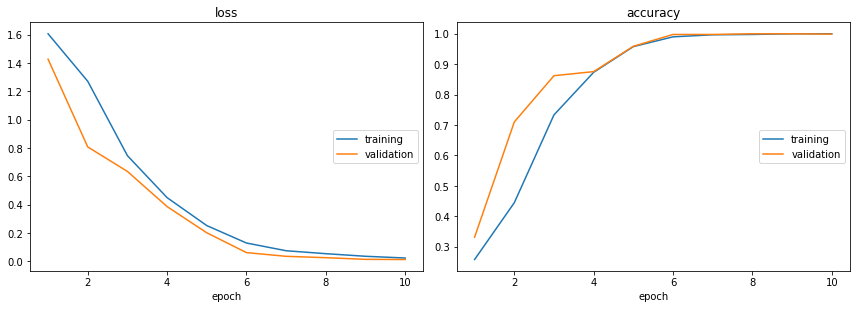

loss:
training   (min:    0.023, max:    1.606, cur:    0.023)
validation (min:    0.012, max:    1.427, cur:    0.012)

accuracy:
training   (min:    0.258, max:    1.000, cur:    1.000)
validation (min:    0.331, max:    1.000, cur:    0.999)


In [8]:
liveloss = PlotLosses(skip_first=0)
for epoch in range(epochs):
    running_loss = 0
    running_correct = 0
    validation_correct = 0
    validation_loss = 0
    cnt = 0
    logs={}
    for i, data in enumerate(trainloader):
        model.train()
        inputs, labels = data
        inputs = inputs[:,None,:,:].float().to(device) 
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels[:].long().to(device)
        loss = criterion(outputs, labels-1)
        loss.backward()
#         plot_grad_flow(model.named_parameters())
        optimizer.step()
        running_loss += loss.item()
        running_correct += torch.sum(outputs.argmax(1) == labels-1).item()
        cnt += len(labels)
        print('\r[%d, %5d] Train_loss: %.3f' %(epoch + 1, i + 1, running_loss/(i+1)),end='')
    logs['loss'] = running_loss/(i+1)
    logs['accuracy'] = running_correct/cnt
    cnt = 0
    for i, data in enumerate(validationloader):
        model.eval()
        with torch.no_grad():
            inputs, labels = data
            inputs = inputs[:,None,:,:].float().to(device) 
            labels = labels[:].long().to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels-1)
            validation_loss += loss.item()
            validation_correct += torch.sum(outputs.argmax(1) == labels-1).item()
            cnt += len(labels)
        
    logs['val_loss'] = validation_loss/(i+1)
    logs['val_accuracy'] = validation_correct/cnt
    liveloss.update(logs)
    liveloss.draw()
#     print('\r[%d, %5d] Validation_loss: %.3f' % (epoch+1, i+1, validation_loss/(i+1)))
#     print('[%d] Validation_Acc: %.3f' % (epoch+1, running_correct/cnt))

In [17]:
logs

{'loss': 0.021052478005488713,
 'accuracy': 0.9977777777777778,
 'val_loss': 0.007273580759970678,
 'val_accuracy': 0.9988888888888889,
 '_i': 10}

In [23]:
torch.sum(outputs.argmax(1) == labels-1).item()

14

In [30]:
running_correct

1738

In [21]:
testdata = pickle.load(bz2.BZ2File('data/test.pickle.bz2','r'))

In [24]:
testimg = torch.Tensor(testdata[0][0]).float().to(device)

In [8]:
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)

In [17]:
outputs.sigmoid().argmax(1)

tensor([3, 3, 0, 1, 2, 1], device='cuda:0')

In [20]:
labels-1

tensor([3, 3, 0, 1, 2, 1], device='cuda:0')

In [73]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [72]:
vgg16 = models.vgg16(pretrained=True)

In [12]:
models.vgg16??

Signature: models.vgg16(pretrained=False, progress=True, **kwargs)
Source:   
def vgg16(pretrained=False, progress=True, **kwargs):
    r"""VGG 16-layer model (configuration "D")
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg16', 'D', False, pretrained, progress, **kwargs)
File:      ~/anaconda3/envs/candid/lib/python3.6/site-packages/torchvision/models/vgg.py
Type:      function
